## Brief & Summary: 
### Aim:
Build a model using the ‘data.csv’ employing either R or Python, with the goal of predicting if an
individual has heart disease.
### Summary:
- Data Cleaning: I found 723 duplicates, and removed them after testing the dataset's efficacy in model training; corrected data object types, researched and found incorrect or missing data values in the data dictionary. Removed missing values
- Data Exploration and feature analysis: Plotted density plots for numerical features (age, cholesterol, etc.) to see how they differ between individuals with and without heart disease. Created count plots for categorical features (sex, chest pain type, etc.) to visualise category distributions across heart disease groups. Utilised Point Biserial correlation, and cramer's v. Features have weak correlation with each other, and some show moderate correlations with the target variable.
- Model training: Defined Ten baseline models, fitted and computed metrics (Accuracy, precision, recall, f1 score). I identified top performers and optimised parameters using Optuna
- Model Explainability: Coefficient Plot for Logistic Regression, Permutation Importance for LightGBM and Random Forest

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [450]:
data = pd.read_csv('/Users/tuoyosmachine/Documents/Liberty IT Takehome/data_2.csv')

In [341]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,ecg,max_heart_rate,exercise_induced_chest_pain,st_depression,st_slope,stained_blood_vessels,blood_disorder,heart_disease
0,52,Male,Typical Angina,125,212,Normal,Abnormality Type A,168,No Pain Observed,1.0,Upsloping,2,Reversible Damage,0
1,53,Male,Typical Angina,140,203,Abnormally High,Normal,155,Chest Pain Observed during Exercise,3.1,Downsloping,0,Reversible Damage,0
2,70,Male,Typical Angina,145,174,Normal,Abnormality Type A,125,Chest Pain Observed during Exercise,2.6,Downsloping,0,Reversible Damage,0
3,61,Male,Typical Angina,148,203,Normal,Abnormality Type A,161,No Pain Observed,0.0,Upsloping,1,Reversible Damage,0
4,62,Female,Typical Angina,138,294,Abnormally High,Abnormality Type A,106,No Pain Observed,1.9,Flat,3,Normal,0


# Outline
1. Data Cleaning
2. Data Exploration
3. Feature Exploration
    - Correlation Analysis
4. Predictive Modelling and Assessment
5. Model Explainability.
6. Summary

In [144]:
data.shape

(1025, 14)

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          1025 non-null   int64  
 1   sex                          1025 non-null   int64  
 2   chest_pain_type              1025 non-null   int64  
 3   resting_blood_pressure       1025 non-null   int64  
 4   cholesterol                  1025 non-null   int64  
 5   fasting_blood_sugar          1025 non-null   int64  
 6   ecg                          1025 non-null   int64  
 7   max_heart_rate               1025 non-null   int64  
 8   exercise_induced_chest_pain  1025 non-null   int64  
 9   st_depression                1025 non-null   float64
 10  st_slope                     1025 non-null   int64  
 11  stained_blood_vessels        1025 non-null   int64  
 12  blood_disorder               1025 non-null   int64  
 13  heart_disease     

## **Description of Data**
The file contains information on 1,000 patients who were screened for heart disease.
In total, 13 variables were recorded in relation to their diagnosis (diseased or not diseased), the 14th variable is the response variable:
1. **age** - An individuals recorded age in years.
2. **sex** - Female = 0; Male = 1
3. **chest_pain_type** - Typical Angina = 0, Atypical Angina = 1, Non-Anginal Pain = 2 and Asymptomatic = 3; 0-2 can
be interpreted as some form of chest pain, 3, as no chest pain observed.
4. **resting_blood_pressure** - Systolic Blood Pressure. Values of <= 120 can be considered normal/healthy and values >120 are abnormal.
5. **cholesterol** - Circulating blood cholesterol in mg/dl. Larger values can be considered unhealthy.
6. **fasting_blood_sugar** - Normal = 0, Abnormally High = 1
7. **ecg**- Results from an ECG test. Normal = 0, abnormality type A = 1, abnormality type B = 2
8. **max_heart_rate** - Maximum resting heartrate in Beats Per Minute (BPM)
9. **exercise_induced_chest_pain** - No Pain Observed = 0, Chest Pain Observed During Exercise = 1
10. **st_depression** - ST Depression induced by exercise relative to rest. Higher values can be considered abnormal.
11. **st_slope** - The slope of the peak exercise ST segment
12. **stained_blood_vessels** - Number of blood vessels with observed plaque build-up. A larger number can be considered unhealthy.
13. **blood_disorder** - Blood Disorder: Normal = 0, Irreversible Damage = 1, Reversible Damage = 2
14. **heart_disease** - Response variable, No disease = 0, Heart Disease Present = 1

There is no identifier column in this dataset, so it is not very straightforward to check for duplicates. I used duplicated() to check where there are the exact same entries for every column in a row.

In [451]:
duplicates = data.duplicated().sum()
print(duplicates)

723


In [147]:
# duplicated_rows = data[data.duplicated(keep= 'first')]
# duplicated_rows.sort_values(by= duplicated_rows.columns.tolist())

There are 723 duplicated rows. Humans generally show some variability. I think it's suspicious to be frank, that this has occurred randomly. I checked the internet for the dataset, and found that the duplicates were added at an attempt to artificially increase the sample size.  At this point, I am unsure whether to remove or keep them. I am curious to see how the model performs when trained with no duplicates, and how it performs with the duplicates left in the dataset.

post edit: training with duplicate data leads to data leakage hence overfitting


In [452]:
data['sex']= data['sex'].replace({0:'Female', 1:'Male'})
data['chest_pain_type']= data['chest_pain_type'].replace({0:'Typical Angina', 1:'Atypical Angina', 2:'Non-Anginal Pain', 3:'Asymptomatic Pain'})
data['fasting_blood_sugar']= data['fasting_blood_sugar'].replace({0:'Normal', 1:'Abnormally High'})
data['ecg']= data['ecg'].replace({0:'Normal', 1:'Abnormality Type A', 2:'Abnormality Type B'})
data['exercise_induced_chest_pain']= data['exercise_induced_chest_pain'].replace({0:'No Pain Observed', 1:'Chest Pain Observed during Exercise'})
data['st_slope']= data['st_slope'].replace({0:'Downsloping', 1:'Flat', 2:'Upsloping'})
data['blood_disorder']= data['blood_disorder'].replace({0:np.nan, 1:'Irreversible Damage',2:'Normal', 3:'Reversible Damage'})

In [453]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          1025 non-null   int64  
 1   sex                          1025 non-null   object 
 2   chest_pain_type              1025 non-null   object 
 3   resting_blood_pressure       1025 non-null   int64  
 4   cholesterol                  1025 non-null   int64  
 5   fasting_blood_sugar          1025 non-null   object 
 6   ecg                          1025 non-null   object 
 7   max_heart_rate               1025 non-null   int64  
 8   exercise_induced_chest_pain  1025 non-null   object 
 9   st_depression                1025 non-null   float64
 10  st_slope                     1025 non-null   object 
 11  stained_blood_vessels        1025 non-null   int64  
 12  blood_disorder               1018 non-null   object 
 13  heart_disease     

In [151]:
data['blood_disorder'].value_counts()

blood_disorder
Normal                 544
Reversible Damage      410
Irreversible Damage     64
Name: count, dtype: int64

From digging all over the internet, the actual blood disorder value of 0 is null, 1- fixed defect, 2- Normal, 3- Reversible defect. After changing these, i dropped missing data

In [456]:
#drop the missing data in the dataset
data = data.dropna()

In [457]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          1018 non-null   int64  
 1   sex                          1018 non-null   object 
 2   chest_pain_type              1018 non-null   object 
 3   resting_blood_pressure       1018 non-null   int64  
 4   cholesterol                  1018 non-null   int64  
 5   fasting_blood_sugar          1018 non-null   object 
 6   ecg                          1018 non-null   object 
 7   max_heart_rate               1018 non-null   int64  
 8   exercise_induced_chest_pain  1018 non-null   object 
 9   st_depression                1018 non-null   float64
 10  st_slope                     1018 non-null   object 
 11  stained_blood_vessels        1018 non-null   int64  
 12  blood_disorder               1018 non-null   object 
 13  heart_disease          

In [154]:
data['st_slope'].value_counts()

st_slope
Flat           478
Upsloping      466
Downsloping     74
Name: count, dtype: int64

### Now, Data Exploration

In [458]:
distinct_data = data.drop_duplicates(keep='first')
print(distinct_data.shape)

(300, 14)


In [463]:
numerical_features = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression','stained_blood_vessels']
categorical_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'ecg', 'exercise_induced_chest_pain', 'st_slope', 'blood_disorder', 'heart_disease']

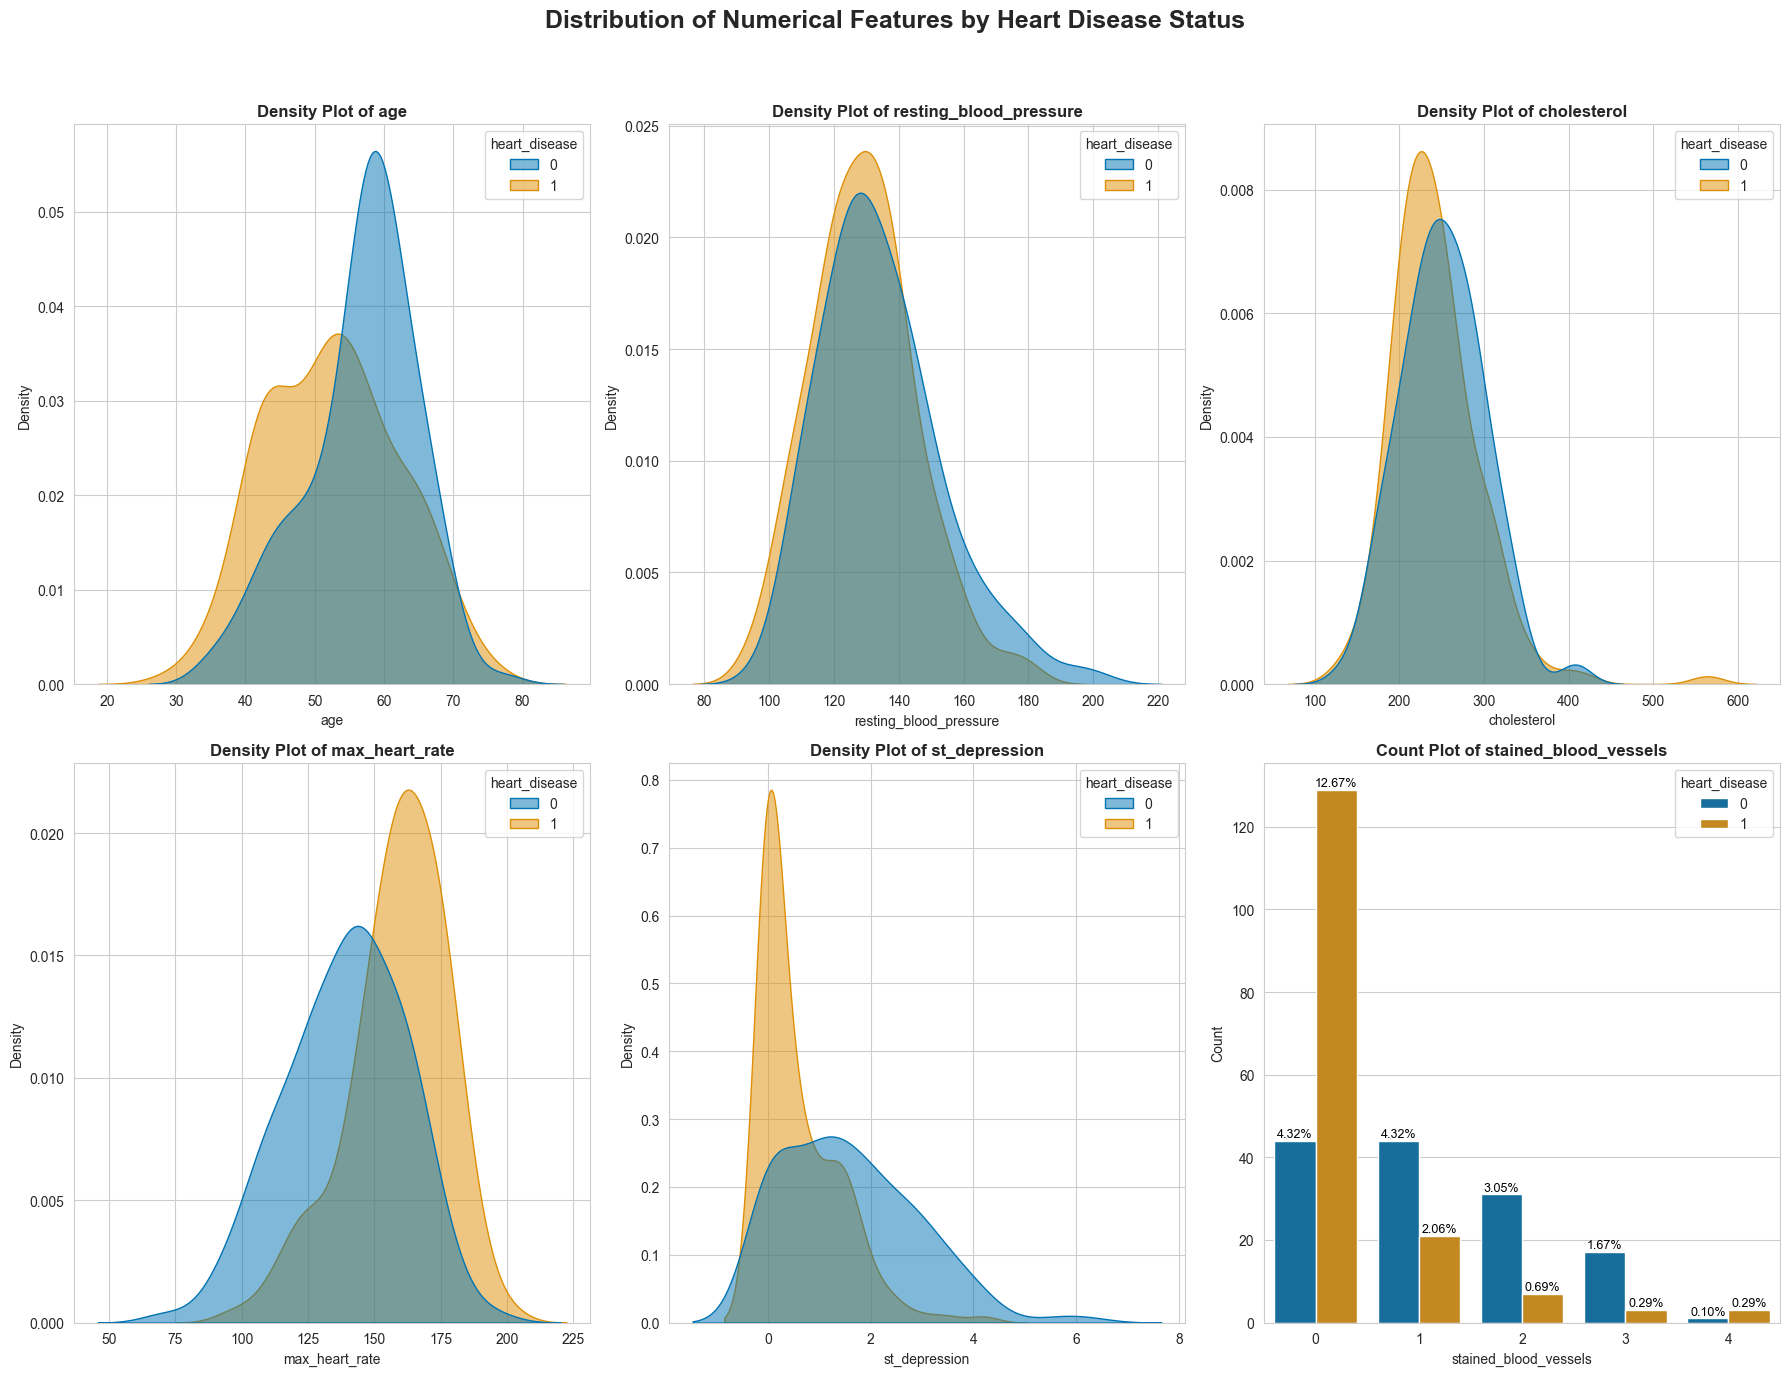

In [459]:
# Set the Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 14))
fig.suptitle("Distribution of Numerical Features by Heart Disease Status", fontsize=18, fontweight='bold')

for i, feature in enumerate(numerical_features):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    if feature != 'stained_blood_vessels':
        # Density plot for numerical features
        sns.kdeplot(data=distinct_data, x=feature, hue='heart_disease', ax=ax, common_norm=False, fill=True, alpha=0.5)
        ax.set_title(f'Density Plot of {feature}', fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density', fontsize= 10)
    else:
        # Count plot for the last feature
        sns.countplot(data=distinct_data, x=feature, hue='heart_disease', ax=ax)
        ax.set_title(f'Count Plot of {feature}', fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count', fontsize= 10)
        total = len(data)
        for p in ax.patches:
            if p.get_height() > 0:
                percentage = f'{100*p.get_height()/total:.2f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha= 'center', va= 'center', fontsize= 9, color = 'black', xytext=(0, 5), textcoords='offset points')
                
# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [464]:
distinct_data[numerical_features].corr()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,stained_blood_vessels
age,1.000000,0.282915,0.206558,-0.397405,0.205844,0.301811
resting_blood_pressure,0.282915,1.000000,0.124519,-0.049065,0.194248,0.098451
cholesterol,0.206558,0.124519,1.000000,-0.007559,0.048360,0.083797
max_heart_rate,-0.397405,-0.049065,-0.007559,1.000000,-0.348520,-0.232553
st_depression,0.205844,0.194248,0.048360,-0.348520,1.000000,0.235045
stained_blood_vessels,0.301811,0.098451,0.083797,-0.232553,0.235045,1.000000


I can take note of very little correlation amongst these numerical variables. There are weak correlations between the following
- Age and every other numerical variable
- Resting blood pressure, cholesterol, st_depression and stained_blood_vessels (very weak)
- Max heart rate and st_depression, stained_blood_vessels
- st_depression and stained_blood_vessels

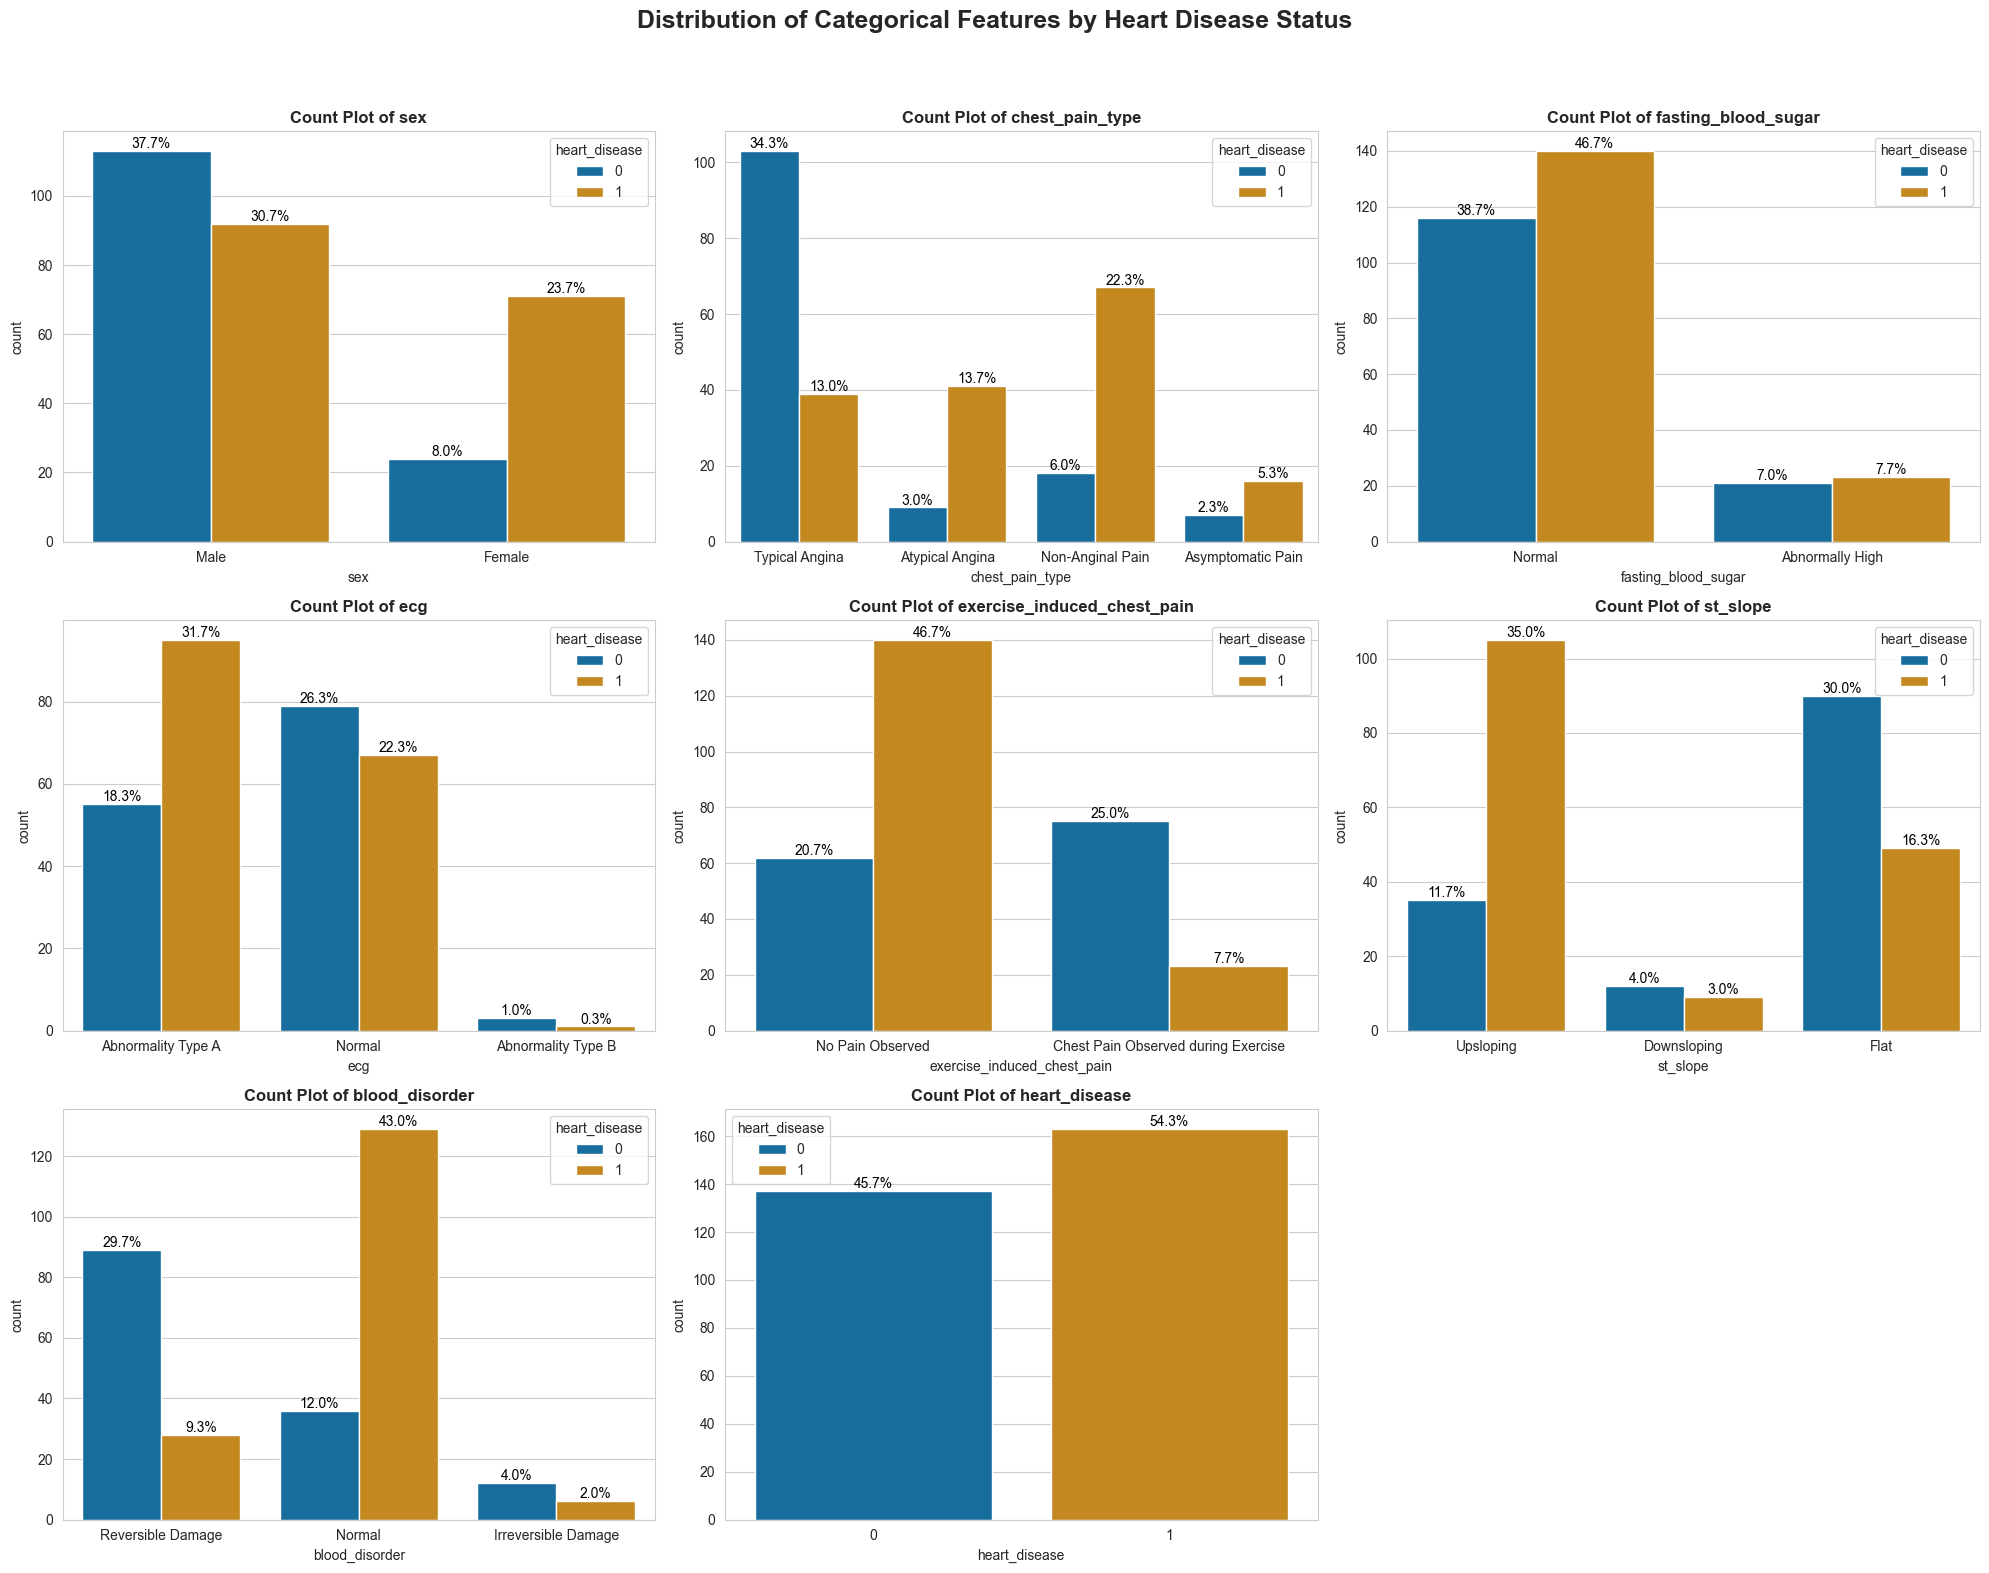

In [472]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 16)) 
fig.suptitle("Distribution of Categorical Features by Heart Disease Status", 
             fontsize=18, fontweight='bold')

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=distinct_data, x=feature, hue='heart_disease', palette='colorblind', ax=ax)
    ax.set_title(f'Count Plot of {feature}', fontweight='bold')

    # Calculate and annotate percentages
    total_counts = len(distinct_data)
    for p in ax.patches:
        if p.get_height() > 0:
            percentage = f'{100 * p.get_height() / total_counts:.1f}%'
            ax.annotate(percentage, 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')

# Remove unused subplot
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])
# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [469]:
distinct_data[categorical_features].describe(include='all')

,sex,chest_pain_type,fasting_blood_sugar,ecg,exercise_induced_chest_pain,st_slope,blood_disorder,heart_disease
count,300,300,300,300,300,300,300,300.000000
unique,2,4,2,3,2,3,3,NaN
top,Male,Typical Angina,Normal,Abnormality Type A,No Pain Observed,Upsloping,Normal,NaN
freq,205,142,256,150,202,140,165,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543333
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498951
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


### Feature Exploration- Indepth Correlation Analysis
**Numerical Features Vs Target:** Point-biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Similar to the Pearson correlation coefficient, the point-biserial correlation coefficient takes on a value between -1 and 1.

**Categorical Features Vs Target:** Cramer's V, used to test the association between categrical variables. It is based upon chi2 contigency which checks for an association.

In [467]:
#Point Biserial Correlation of Numerical Features AND target variable (heart disease)
import scipy.stats as stats
correlation_results = {}

for feature in numerical_features:
    correlation, p_value = stats.pointbiserialr(distinct_data[feature], distinct_data['heart_disease'])
    correlation_results[feature] = {'Correlation': round(correlation, 3), 'P-value': round(p_value, 4)}

# Convert to DataFrame for better readability
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')

# Display the results
print(correlation_df)

                        Correlation  P-value
age                          -0.223   0.0001
resting_blood_pressure       -0.147   0.0108
cholesterol                  -0.083   0.1514
max_heart_rate                0.429   0.0000
st_depression                -0.429   0.0000
stained_blood_vessels        -0.411   0.0000


Max_heart_rate, st_depression, and stained_blood_vessels have the strongest correlations with the target variable (albeit weak-moderate but significant at the p-value) amongst the numerical features.

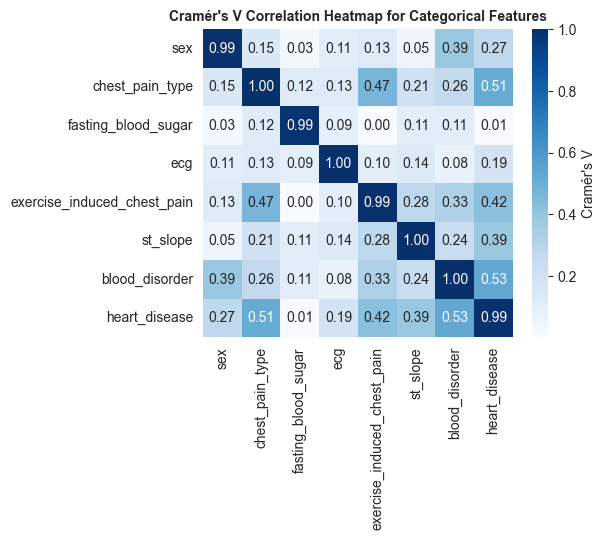

In [470]:
from scipy.stats import chi2_contingency
# Function to calculate Cramér's V without bias correction
def cramer_v(label, x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    v = np.sqrt(chi2 / (n * min(r - 1, k - 1)))
    return v

# Function to plot Cramér's V heatmap
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            try:
                cramer.loc[col1, col2] = cramer_v(df[col1], df[col2])
            except Exception as e:
                cramer.loc[col1, col2] = np.nan
                print(f"Error calculating Cramér's V for {col1} vs {col2}: {e}")

    # Convert to float for heatmap
    cramer = cramer.astype(float)

    # Plot the heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cramer, annot=True, cmap='Blues', fmt='.2f', cbar_kws={'label': "Cramér's V"})
    plt.title("Cramér's V Correlation Heatmap for Categorical Features", fontsize=10, fontweight='bold')
    plt.show()

# Create a new dataframe with only categorical features
categorical_df = distinct_data[categorical_features]

# Generate the heatmap
plot_cramer(categorical_df)

Models:
- Logistic Regression
- KNN Classifiers
- Decision Trees
- Support Vector Classification, LinearSVC
- Random Forest
- Gradient Boost
- Linear DA
- LightGBM
- XGBoost

In [410]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import scipy

In [261]:
#attempt with duplicated data
X = data.drop('heart_disease', axis=1)
y= data['heart_disease']

#split into Training and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify= y)

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features[:-1]),
    ], remainder= 'passthrough'
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


In [262]:
#define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=40),
    'KNN Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear SVC': LinearSVC(random_state=40),
    'Support Vector Classifier': SVC(kernel='rbf', random_state=40),
    'Random Forest': RandomForestClassifier(random_state=40),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Linear DA': LinearDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(objective= 'binary:logistic',random_state=40),
    'lightgbm': LGBMClassifier(verbose = -1)
}

model_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    model_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
model_df = pd.DataFrame(model_results).T
model_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.833333,0.798319,0.904762,0.848214
KNN Classifier,0.833333,0.838095,0.838095,0.838095
Decision Tree,1.000000,1.000000,1.000000,1.000000
Linear SVC,0.828431,0.796610,0.895238,0.843049
Support Vector Classifier,0.867647,0.848214,0.904762,0.875576
Random Forest,1.000000,1.000000,1.000000,1.000000
Gradient Boosting,0.936275,0.942308,0.933333,0.937799
Linear DA,0.828431,0.796610,0.895238,0.843049
XGBoost,1.000000,1.000000,1.000000,1.000000
lightgbm,1.000000,1.000000,1.000000,1.000000


In [424]:
# Splitting Data
X = distinct_data.drop('heart_disease', axis=1)
y = distinct_data['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

numerical_transformer = StandardScaler()
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Define tree-based models (do not need one-hot encoding)
tree_models = ['Decision Tree', 'Random Forest', 'XGBoost', 'lightgbm', 'Gradient Boosting']

# Define preprocessing pipelines
preprocessor_with_ohe = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', one_hot_encoder, categorical_features[:-1]),
    ],
    remainder='passthrough'
)

preprocessor_with_ordinal = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', ordinal_encoder, categorical_features[:-1]),
    ],
    remainder='passthrough'
)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=40),
    'KNN Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear SVC': LinearSVC(random_state=40),
    'Support Vector Classifier': SVC(kernel='rbf', random_state=40),
    'Random Forest': RandomForestClassifier(random_state=40),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Linear DA': LinearDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(objective='binary:logistic', random_state=40),
    'lightgbm': LGBMClassifier(verbose=-1),
}

model_results = {}
predictions = {}

X_train_ohe = preprocessor_with_ohe.fit_transform(X_train)
X_test_ohe = preprocessor_with_ohe.transform(X_test)

X_train_ord = preprocessor_with_ordinal.fit_transform(X_train)
X_test_ord = preprocessor_with_ordinal.transform(X_test)

# Use the correct version for each model
for name, model in models.items():
    if name in tree_models:
        X_train_processed = X_train_ord
        X_test_processed = X_test_ord
    else:
        X_train_processed = X_train_ohe
        X_test_processed = X_test_ohe

    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)

    predictions[name] = y_pred
    # Get predicted probabilities (only for classifiers that support it)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]  # Probability of class 1
    elif hasattr(model, "decision_function"):  # For models like LinearSVC
        y_pred_proba = model.decision_function(X_test_processed)
    else:
        y_pred_proba = y_pred
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC_AUC': auc(fpr, tpr)
    }
    
model_df = pd.DataFrame(model_results).T.sort_values(by=['F1 Score'], ascending=False)

- Accuracy: The fraction of all predictions (both positive and negative) that the model gets correct.
- Precision: Of all the instances the model labeled as positive, the fraction that are actually positive.
- Recall: Of all the actual positives in the dataset, the fraction the model correctly identifies as positive.
- f1: The harmonic mean of precision and recall

In [425]:
model_df

,Accuracy,Precision,Recall,F1 Score,ROC_AUC
Random Forest,0.900000,0.864865,0.969697,0.914286,0.858586
Logistic Regression,0.866667,0.820513,0.969697,0.888889,0.858586
Support Vector Classifier,0.866667,0.820513,0.969697,0.888889,0.858586
Linear DA,0.866667,0.820513,0.969697,0.888889,0.858586
Decision Tree,0.866667,0.837838,0.939394,0.885714,0.858586
lightgbm,0.866667,0.837838,0.939394,0.885714,0.858586
KNN Classifier,0.850000,0.815789,0.939394,0.873239,0.858586
Linear SVC,0.850000,0.815789,0.939394,0.873239,0.858586
Gradient Boosting,0.850000,0.833333,0.909091,0.869565,0.858586
XGBoost,0.833333,0.810811,0.909091,0.857143,0.858586


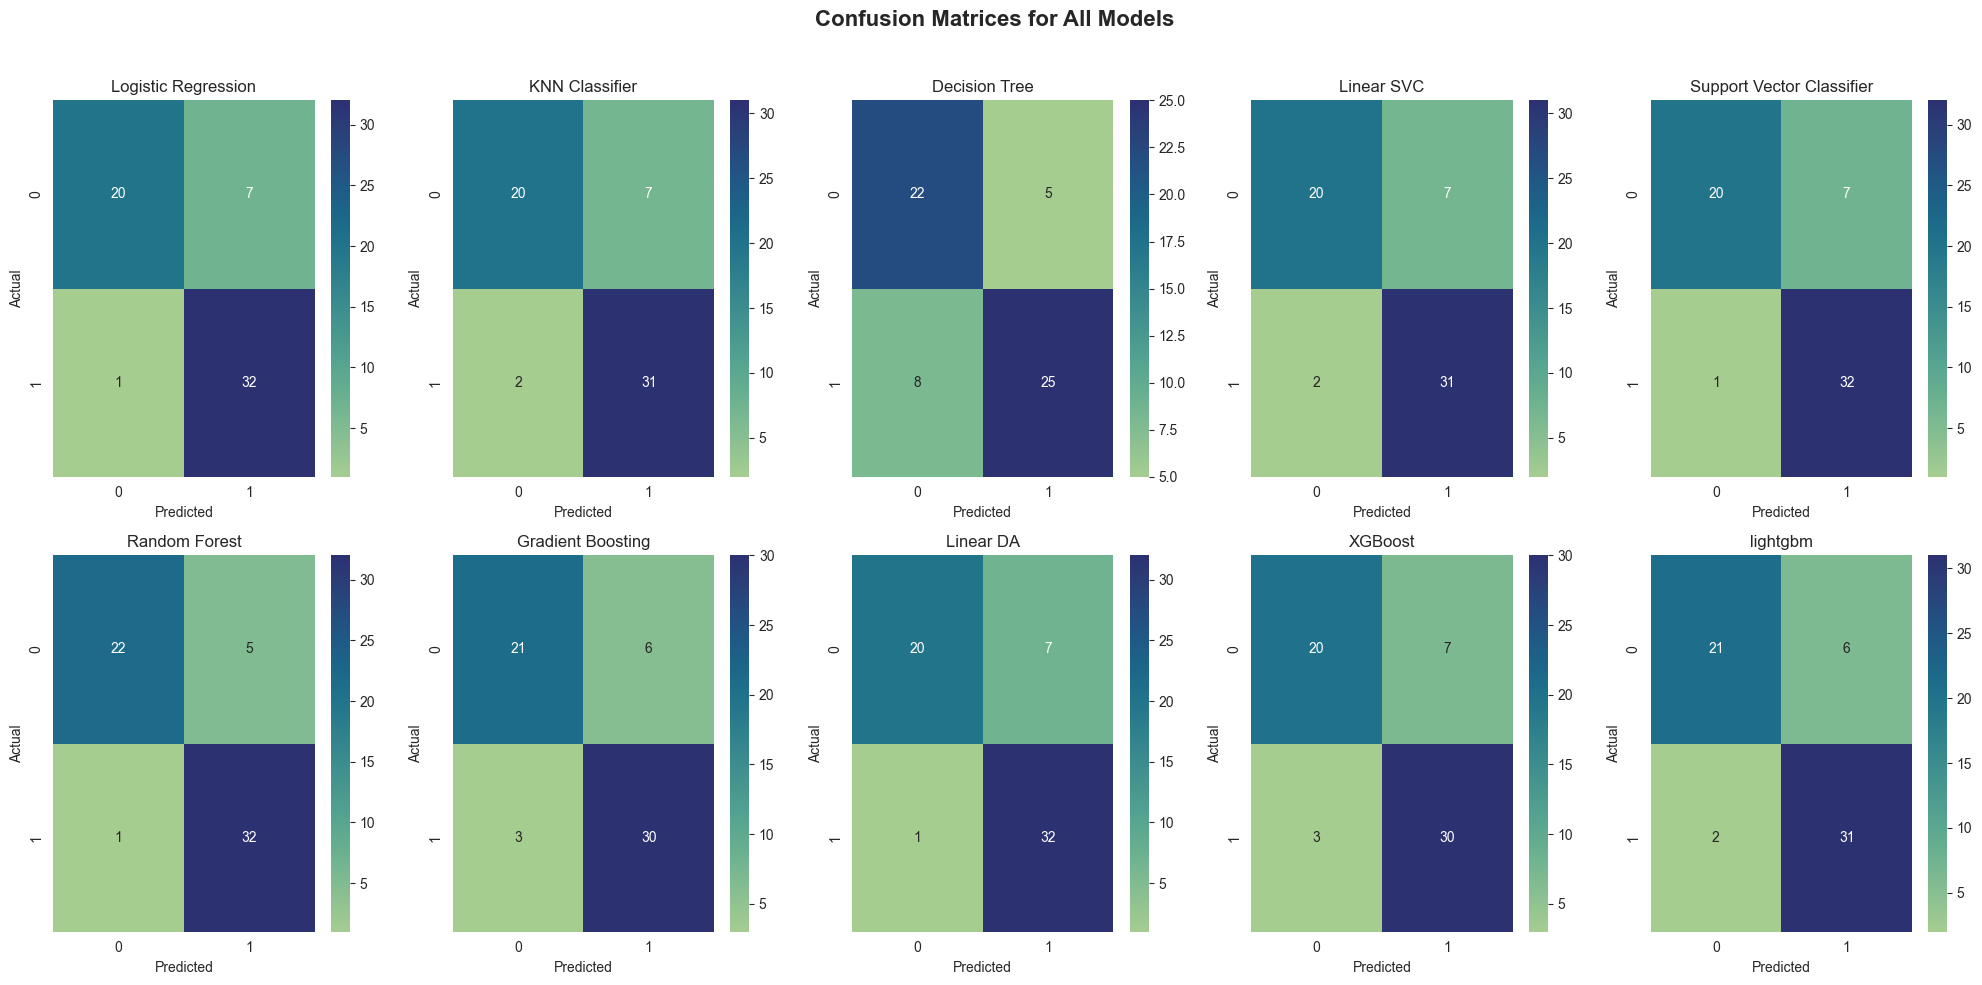

In [413]:
# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

for ax, (name, y_pred) in zip(axes.ravel(), predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='crest', fmt='g', ax=ax)
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

I used Claude AI for the optimisation process using Optuna. 

Prompt: I want to improve the performance of the three models, logistic, xgboost and lightgbm. In the most efficient way in terms of time. I don't want randomised search or grid search, bayesian optimisation is preferable.

Response: For efficient optimization without full grid/random search, let's use Optuna for hyperparameter tuning. It uses Bayesian optimization which is much faster than grid/random search. This optimization approach: 
- Uses Optuna's Bayesian optimization to efficiently search the parameter space
- Runs only 20 trials per model (adjust based on your time constraints)
- Optimizes the most important parameters for each model
- Uses F1 score as the optimization metric

In [444]:
import optuna
# Logistic Regression optimisation
def objective_logistic(trial):
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'])
    if solver in ['lbfgs', 'newton-cg', 'sag']:
        penalty = 'l2'  # These solvers only support L2
    elif solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])  # Supports L1 and L2
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = 5000

    model = LogisticRegression(C=C, solver=solver,penalty= penalty, max_iter=max_iter, random_state=40)
    model.fit(X_train_ohe, y_train)
    y_pred = model.predict(X_test_ohe)
    return f1_score(y_test, y_pred)

# LightGBM optimisation
def objective_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }

    model = LGBMClassifier(random_state=40, verbose=-1, **param)
    model.fit(X_train_ord, y_train)
    y_pred = model.predict(X_test_ord)
    return f1_score(y_test, y_pred)

#Random Forest optimisation
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    model = RandomForestClassifier(random_state=40, **param)
    model.fit(X_train_ord, y_train)
    y_pred = model.predict(X_test_ord)

    return f1_score(y_test, y_pred)


# Run optimisation
n_trials = 50

# Optimise Logistic Regression
study_log = optuna.create_study(direction='maximize', study_name="LogisticRegressionOptimization")
study_log.optimize(objective_logistic, n_trials=n_trials)

# Optimise LightGBM
study_lgb = optuna.create_study(direction='maximize', study_name="LightGBMOptimization")
study_lgb.optimize(objective_lgb, n_trials=n_trials)

#Optimise Random Forest
study_rf = optuna.create_study(direction='maximize', study_name="RandomForestOptimization")
study_rf.optimize(objective_rf, n_trials=n_trials)

# Get best models with optimized parameters
best_log = LogisticRegression(**study_log.best_params, random_state=40, max_iter=1000)
best_lgb = LGBMClassifier(random_state=40, verbose=-1, **study_lgb.best_params)
best_rf = RandomForestClassifier(random_state=40, **study_rf.best_params)

# Train and evaluate best models
models = {'Logistic': best_log, 'LightGBM': best_lgb, 'Random Forest': best_rf}
results = {}
predictions2 = {}
tree_models = ['Decision Tree', 'Random Forest', 'XGBoost', 'lightgbm', 'Gradient Boosting']
for name, model in models.items():
    if name in tree_models:
        X_train_processed = X_train_ord
        X_test_processed = X_test_ord
    else:
        X_train_processed = X_train_ohe
        X_test_processed = X_test_ohe
    
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)


    predictions2[name] = y_pred
    results[name] = {
        'F1 Score': f1_score(y_test, y_pred),
        # 'ROC_AUC': roc_auc,
        'Best Parameters': (
            study_log.best_params if name == 'Logistic' else 
            study_lgb.best_params if name == 'LightGBM' else 
            study_rf.best_params
        )
    }

results_df = pd.DataFrame({k: {m: v[m] for m in ['F1 Score']} 
                          for k, v in results.items()}).T
print("\nOptimized Model Results:")
print(results_df)
print("\nBest Parameters:")
for name, result in results.items():
    print(f"\n{name}:")
    print(result['Best Parameters'])

[I 2025-02-19 08:28:30,159] A new study created in memory with name: LogisticRegressionOptimization
[I 2025-02-19 08:28:30,173] Trial 0 finished with value: 0.8888888888888888 and parameters: {'C': 1.8334873009480128, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8888888888888888.
[I 2025-02-19 08:28:30,176] Trial 1 finished with value: 0.8732394366197183 and parameters: {'C': 6.971905414519194, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8888888888888888.
[I 2025-02-19 08:28:30,178] Trial 2 finished with value: 0.7096774193548387 and parameters: {'C': 0.00011355488605646976, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8888888888888888.
[I 2025-02-19 08:28:30,222] Trial 3 finished with value: 0.8571428571428571 and parameters: {'C': 475.67566260014837, 'solver': 'sag'}. Best is trial 0 with value: 0.8888888888888888.
[I 2025-02-19 08:28:30,225] Trial 4 finished with value: 0.717391304347826 and parameters: {'C': 0.0005447112291819656, 'solver': 'lbfgs'}. Best is trial 0


Optimized Model Results:
               F1 Score
Logistic       0.901408
LightGBM       0.873239
Random Forest  0.901408

Best Parameters:

Logistic:
{'C': 0.19378217663780223, 'solver': 'newton-cg'}

LightGBM:
{'n_estimators': 64, 'learning_rate': 0.08832290197188397, 'num_leaves': 50, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6408961153973906, 'colsample_bytree': 0.9735466699413331}

Random Forest:
{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}


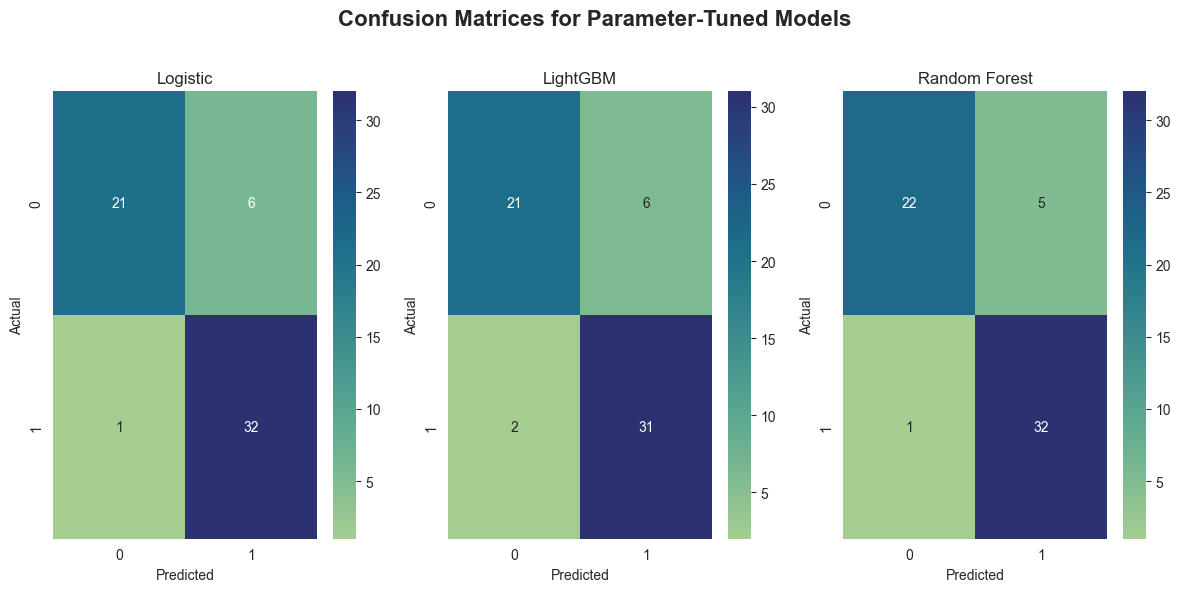

In [436]:
# Plot Confusion Matrices for parameter tuned models
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Confusion Matrices for Parameter-Tuned Models', fontsize=16, fontweight='bold')

for ax, (name, y_pred) in zip(axes.ravel(), predictions2.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='crest', fmt='g', ax=ax)
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Explainability

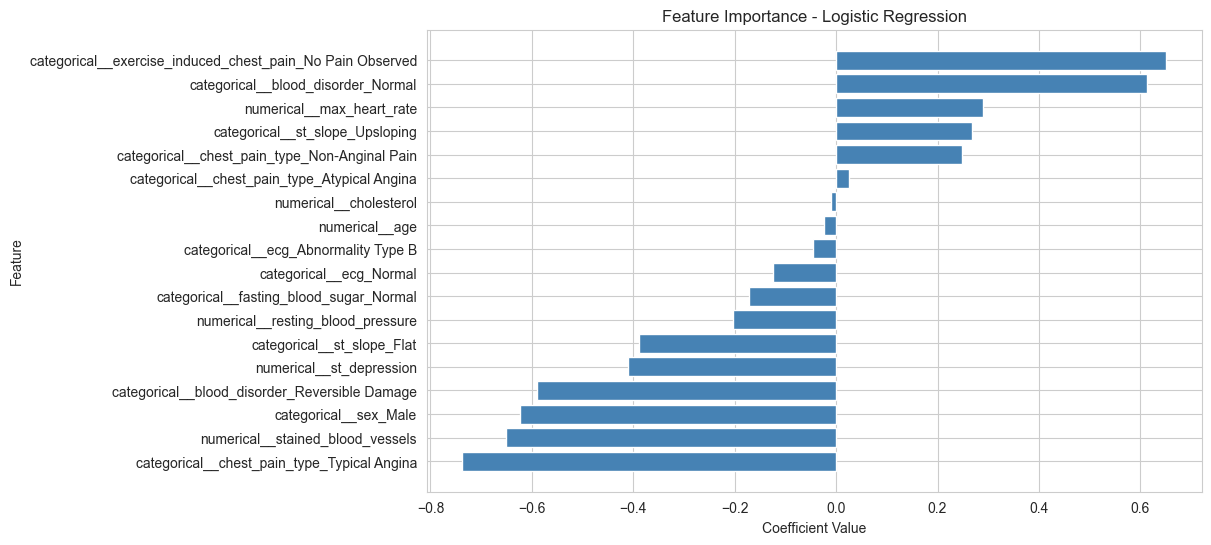

In [438]:
best_log.fit(X_train_ohe, y_train)

# Get feature names after one-hot encoding
feature_names = preprocessor_with_ohe.get_feature_names_out()

# Extract coefficients and sort them by importance
coef = best_log.coef_.flatten()
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='steelblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance - Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

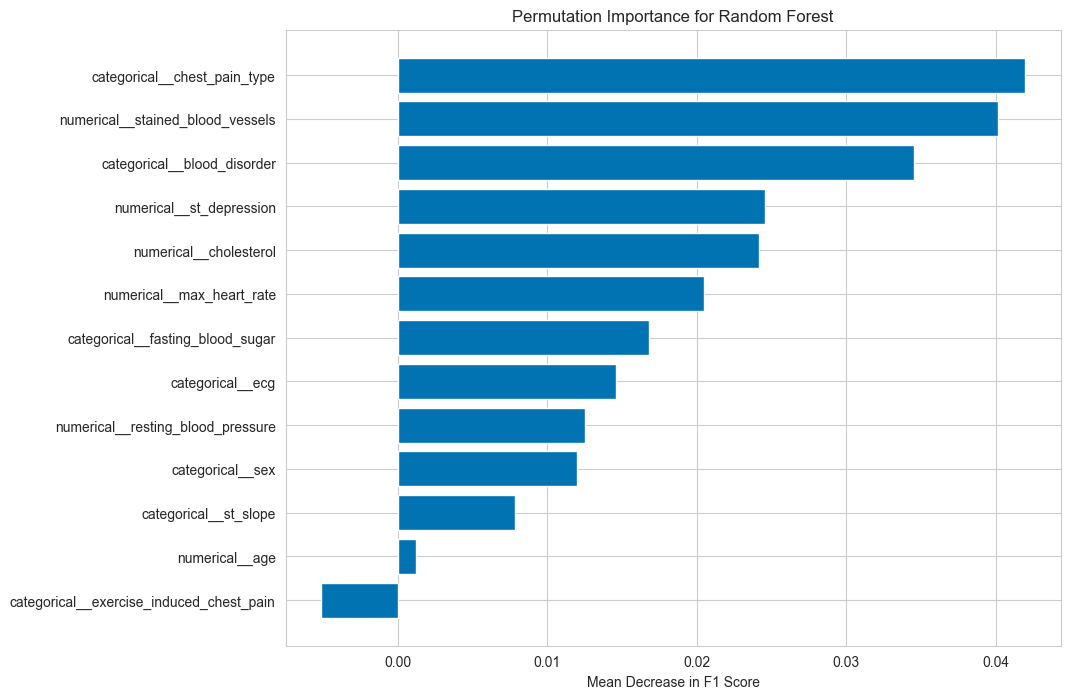

In [446]:
#permutation importance for the best random forest model
perm_importance_rf = permutation_importance(best_rf, X_test_ord, y_test, n_repeats=30,random_state=40, scoring='f1')

feature_names = preprocessor_with_ordinal.get_feature_names_out()

# Sort feature indices by importance (mean decrease in F1 score)
sorted_idx = perm_importance_rf.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], perm_importance_rf.importances_mean[sorted_idx])
plt.xlabel("Mean Decrease in F1 Score")
plt.title("Permutation Importance for Random Forest")
plt.show()